In [1]:
%matplotlib inline
%load_ext Cython

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs 
from numba import jit, vectorize, float64, int64

In [3]:
sns.set_context('notebook', font_scale=1.5)

# Lab10: Making Python faster

This homework provides practice in making Python code faster. Note that we start with functions that already use idiomatic `numpy` (which are about two orders of magnitude faster than the pure Python versions).

**Functions to optimize**

In [4]:
def logistic(x):
    """Logistic function."""
    return np.exp(x)/(1 + np.exp(x))

def gd(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

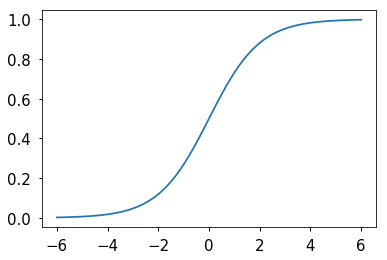

In [5]:
x = np.linspace(-6, 6, 100)
plt.plot(x, logistic(x))
pass

**Data set for classification**

In [6]:
n = 10000
p = 2
X, y = make_blobs(n_samples=n, n_features=p, centers=2, cluster_std=1.05, random_state=23)
X = np.c_[np.ones(len(X)), X]
y = y.astype('float')

**Using gradient descent for classification by logistic regression**

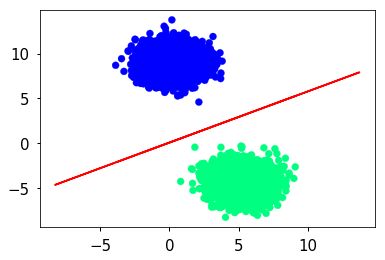

In [7]:
# initial parameters
niter = 1000
α = 0.01
β = np.zeros(p+1)

# call gradient descent
β = gd(X, y, β, α, niter)

# assign labels to points based on prediction
y_pred = logistic(X @ β)
labels = y_pred > 0.5

# calculate separating plane
sep = (-β[0] - β[1] * X)/β[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass

**1**. Rewrite the `logistic` function so it only makes one `np.exp` call. Compare the time of both versions with the input x given below using the `@timeit` magic. (10 points)

In [8]:
np.random.seed(123)
n = int(1e7)
x = np.random.normal(0, 1, n)

**2**. (20 points) Use `numba` to compile the gradient descent function. 

- Use the `@vectorize` decorator to create a ufunc version of the logistic function and call this `logistic_numba_cpu` with function signatures of `float64(float64)`. Create another function called `logistic_numba_parallel` by giving an extra argument to the decorator of `target=parallel` (5 points)
- For each function, check that the answers are the same as with the original logistic function using  `np.testing.assert_array_almost_equal`. Use `%timeit` to compare the three logistic functions (5 points)
- Now use `@jit` to create a JIT_compiled version of the `logistic` and `gd` functions, calling them `logistic_numba` and `gd_numba`. Provide appropriate function signatures to the decorator in each case. (5 points)
- Compare the two gradient descent functions `gd` and `gd_numba` for correctness and performance. (5 points)

**3**. (30 points) Use `cython` to compile the gradient descent function. 

- Cythonize the logistic function as `logistic_cython`. Use the `--annotate` argument to the `cython` magic function to find slow regions. Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (10 points)
- Now cythonize the gd function as `gd_cython`. This function should use of the cythonized `logistic_cython` as a C function call.  Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (20 points)

Hints: 

- Give static types to all variables
- Know how to use `def`, `cdef` and `cpdef`
- Use Typed MemoryViews
- Find out how to transpose a Typed MemoryView to store the transpose of X
- Typed MemoryVeiws are not `numpy` arrays - you often have to write explicit loops to operate on them
- Use the cython boundscheck, wraparound, and cdivision operators

**4**. (40 points) Wrapping modules in C++.

Rewrite the `logistic` and `gd` functions in C++, using `pybind11` to create Python wrappers.  Compare accuracy and performance as usual. Replicate the plotted example using the C++ wrapped functions for `logistic` and `gd`

- Writing a vectorized `logistic` function callable from both C++ and Python (10 points)
- Writing the `gd` function callable from Python (25 points)
- Checking accuracy, benchmarking and creating diagnostic plots (5 points)

Hints:

- Use the C++ `Eigen` library to do vector and matrix operations (include path is `../notebooks/eigen3`)
- When calling the exponential function, you have to use `exp(m.array())` instead of `exp(m)` if you use an Eigen dynamic template.
- Use `cppimport` to simplify the wrapping for Python
- See [`pybind11` docs](http://pybind11.readthedocs.io/en/latest/index.html)
- See my [examples](http://people.duke.edu/~ccc14/cspy/18G_C++_Python_pybind11.html#) for help